<!-- # <span style="color:red">UNDER CONSTRUCTION!!!!</span> -->

# Spoken Language Processing - Instituto Superior Técnico
## Laboratory Assignment 2 - Native Language Identification challenge

# PART 2 - Using pre-trained models


This notebook contains the guide and code cells that permit implementing two advanced systems for native language identification based on:
- speaker representations (utterance-based) obtained with an x-vector model; 
- speech representations (frame-based) obtained with a self-supervised learning (SSL) pre-trained model. 

Besides, the notebook will show how to obtain predictions and score the systems on the development set.

## Before starting

Let's import some modules and make some definitions:

In [1]:
import os 
import csv 
import time
import pickle
import numpy as np

from pf_tools import CheckThisCell, ETS
from speechbrain.inference.classifiers import EncoderClassifier
from speechbrain.utils.data_utils import split_path
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

LANGUAGES = ('CHI',  'GER',  'HIN',  'ITA')
LANG2ID = {'CHI':1, 'GER':2, 'HIN':3, 'ITA':4}
ID2LANG = dict((LANG2ID[k],k)for k in LANG2ID)

/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
torchvision is not available - cannot save figures


Like in the previous Notebooks, you need to mount Google drive if you are working on Google Colab. Otherwise, you should skip or delete the following code cell:

In [ ]:
raise CheckThisCell ## <---- Remove this torun this cell if you are on Google Colab
from google.colab import drive
drive.mount('/content/drive')


Like in Part1, the audio data is expected to be in a folder with the following format:

```
ets_data/
├── train/
│   └── audio/
│       └──wav files
│   └── key.lst 
│
└── train100/
    └── audio/
        └──wav files
    └── key.lst
... 
```

You must already have this from part 1, so you can set-up your data directory:

In [2]:
CWD = os.getcwd()
DATADIR = f'{CWD}/ets_data/' # <--- Change this variable to your working directory containig the ETS data
if not os.path.isdir(DATADIR):
    os.mkdir(DATADIR)
    print(f'WARNING: Your data is not in the folder {DATADIR}')

os.chdir(CWD)
print(f'Your ETS data should be in this folder {DATADIR}')


Your ETS data should be in this folder /home/pmigdalek/spoken-language-processing-23-24-IST/slp-lab2/ets_data/


If you need to download again the data, you can run the following cell:

In [4]:
#raise CheckThisCell

os.chdir(DATADIR)

# download train
!wget http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/train.tgz
!tar -xzvf train.tgz

#download train100
!wget http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/train100.tgz
!tar -xzvf train100.tgz

#download dev
!wget http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/dev.tgz
!tar -xzvf dev.tgz

#download evl
!wget http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/evl.tgz
!tar -xzvf evl.tgz

os.chdir(CWD)

--2024-05-16 16:05:48--  http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/train.tgz
Resolving groups.tecnico.ulisboa.pt (groups.tecnico.ulisboa.pt)... 193.136.128.24, 2001:690:2100:4::d301:2ae9
Connecting to groups.tecnico.ulisboa.pt (groups.tecnico.ulisboa.pt)|193.136.128.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1544228445 (1,4G) [application/x-gzip]
Saving to: ‘train.tgz’

train.tgz           100%[===================>]   1,44G  16,7MB/s    in 68s     

2024-05-16 16:06:56 (21,6 MB/s) - ‘train.tgz’ saved [1544228445/1544228445]

train/
train/key.lst
train/audio/
train/audio/train_0013.wav
train/audio/train_0026.wav
train/audio/train_0047.wav
train/audio/train_0054.wav
train/audio/train_0075.wav
train/audio/train_0076.wav
train/audio/train_0089.wav
train/audio/train_0090.wav
train/audio/train_0096.wav
train/audio/train_0104.wav
train/audio/train_0106.wav
train/audio/train_0110.wav
train/audio/train_0111.wav
train/audio/train_0125.wav
train/audio/

## 2.1 Using pre-trained speaker embeddings (x-vectors)

The goal of this part of the lab is to get familiar with and show how to use pre-trained speaker embedings (a.k.a. x-vectors) for speech classification tasks.

There exist plenty of resources and pre-trained models that can be  useful for our task. In particular, x-vectors are the current state of the art approach to obtain speech embeddings that characterize very efficiently speaker or language, among others. X-vectors are neural models typically trained for speaker identification in a supervised way, but also in some cases for other related tasks, like language recognition. Once trained, they can be used to obtain a single embedding vector of fixed dimension for each audio input. This vector corresponds to the activations of one of the layers after the pooling layer. 

The following are examples of x-vector models available in the `speechbrain` module: 

- `speechbrain/spkrec-ecapa-voxceleb`: trained using a large speaker corpus for speaker verification: https://huggingface.co/speechbrain/spkrec-ecapa-voxceleb

- `speechbrain/lang-id-voxlingua107-ecapa`: trained using a large corpus of 107 languages for language identification: https://huggingface.co/speechbrain/lang-id-voxlingua107-ecapa

- `speechbrain/lang-id-commonlanguage_ecapa`: trained using a large corpus of 45 languages for language identification: https://huggingface.co/speechbrain/lang-id-commonlanguage_ecapa


The following code cell shows how to import one of those models to obtain an embedding vector:

In [3]:
xvector_model = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", savedir=f"{CWD}/tmp/spkrec-ecapa-voxceleb")

signal = xvector_model.load_audio(f'{DATADIR}/train100/audio/train_0005.wav')
emb =  xvector_model.encode_batch(signal, normalize=True)

These (very informative) embedding vectors can be used to train simple models for several speech classification tasks, achieving excellent results. In particular, in this lab assignment, we will train a simple linear SVM on top of these x-vectors. 

### 2.1.1 Extracting x-vectors for the ETS datasets

Just like in Part1, we will code the feature transformation to process all data and obtain x-vectors. In this case, the function should receive as arguments the audio filename and an instance of `EncoderClassifier` (the x-vector model) and return the numpy array with the features. You must complete the following code using the previous example:

In [4]:
# This function receives a filename and one encoder model 
# (for instance, xvector_model object in previous cell example) and returns 
# the extracted x-vectors as a numpy array of shape (1, embedding_dimension).
# Notice that the encoder extractor module generates a softlink to each audio 
# file. To avoid generating "junk", you can delete this link also in the
# function 

def extract_xvec(filename, emb_model):
    
    signal = xvector_model.load_audio(filename)
    embedding = emb_model.encode_batch(signal)

    # Remove the "annoying" soft-link
    _, fl = split_path(filename)
    if os.path.islink(fl):
        os.remove(fl)

    return embedding.squeeze().numpy().reshape(1,-1)

emb = extract_xvec(f'{DATADIR}/train100/audio/train_0005.wav' , xvector_model)

# Check that this shape and type
emb.shape, type(emb)

((1, 192), numpy.ndarray)

Let's generate the x-vectors for all our data sets using the ETS class and store in disk. Like in Part 1, we can keep different transformation configurations in a dictionary for later usage. In this assignment, you can try to different x-vector models.

In [5]:

transform = { 
                'spkrec-ecapa-voxceleb' : 
                {
                    'audio_transform': 
                        lambda x : extract_xvec(x, 
                            emb_model = EncoderClassifier.from_hparams(
                                        source="speechbrain/spkrec-ecapa-voxceleb", # <--- You chan look for different models in speechbrain
                                        savedir=f"{CWD}/tmp/spkrec-ecapa-voxceleb" #,run_opts={"device":"cuda"}
                                        )
                            ),
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }
            }

transform['lang-id-voxlingua107-ecapa'] = {
                    'audio_transform': 
                        lambda x : extract_xvec(x, 
                            emb_model = EncoderClassifier.from_hparams(
                                        source="speechbrain/lang-id-voxlingua107-ecapa", # <--- You chan look for different models in speechbrain
                                        savedir=f"{CWD}/tmp/lang-id-voxlingua107-ecapa" #,run_opts={"device":"cuda"}
                                        )
                            ),
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }

transform['lang-id-commonlanguage_ecapa'] = {
                    'audio_transform': 
                        lambda x : extract_xvec(x, 
                            emb_model = EncoderClassifier.from_hparams(
                                        source="speechbrain/lang-id-commonlanguage_ecapa", # <--- You chan look for different models in speechbrain
                                        savedir=f"{CWD}/tmp/lang-id-commonlanguage_ecapa" #,run_opts={"device":"cuda"}
                                        )
                            ),
                    'chunk_transform': None,
                    'chunk_size': 0,
                    'chunk_hop':0   
                }


# Download and feature extract
trainset = 'train'
transform_id = 'lang-id-commonlanguage_ecapa'

train_ets = ETS(DATADIR, trainset, 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

dev_ets = ETS(DATADIR, 'dev', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

evl_ets = ETS(DATADIR, 'evl', 
                 transform_id=transform_id, 
                 audio_transform=transform[transform_id]['audio_transform'], 
                 chunk_transform=transform[transform_id]['chunk_transform'],
                 chunk_size=transform[transform_id]['chunk_size'], 
                 chunk_hop=transform[transform_id]['chunk_hop']
                )

100%|██████████| 170/170 [02:06<00:00,  1.35it/s]


### 2.1.2 Training the SVM model 

As mentioned before, our native language identification system will be a simple SVM model (4-classes) using x-vectors as features. Similarly to Part 1, we must iterate the ETS data instances to store the x-vectors and the labels in numpy arrays:

In [6]:
# Place train data and reference in a single array train_data and train_label  
start = time.time()
train_data = []
train_labels = []
for data, label, basename in train_ets:
        train_data.append(data)
        train_labels.append(np.full(data.shape[0], label)) 

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)

print(f'Finished reading all data in {time.time() - start}')

# Place dev data and reference in a single array dev_data and dev_label
start = time.time()
dev_data = []
dev_labels = []
dev_filenames = []
for data, label, basename in dev_ets:
        dev_data.append(data)
        dev_labels.append(np.full(data.shape[0], label)) 
        dev_filenames.append(basename)

dev_data = np.concatenate(dev_data)
dev_labels = np.concatenate(dev_labels)

print(f'Finished reading all data in {time.time() - start}')

# Place evl data and reference in a single array evl_data
start = time.time()
evl_data = []
evl_filenames = []
for data, label, basename in evl_ets:
        evl_data.append(data)
        evl_filenames.append(basename)

evl_data = np.concatenate(evl_data)

print(f'Finished reading all data in {time.time() - start}')

Finished reading all data in 0.06493353843688965
Finished reading all data in 0.0060863494873046875
Finished reading all data in 0.0048525333404541016


In [10]:
train_data.shape, dev_data.shape, evl_data.shape

((1200, 256), (176, 256), (170, 256))

Now, we will use `sklearn` linear SVM to train our classifier and save it for later use.

In [ ]:
model = LinearSVC() ### <---- a linear SVM
model.fit(train_data, train_labels)  ## <---- train MODEL

model_path = f'{DATADIR}/{trainset}/models/'
if not os.path.isdir(model_path):
    os.mkdir(model_path)
    
model_name = f'{model_path}/svm_{transform_id}'
os.mkdir(f'{model_name}')

pickle.dump(model, open(f'{model_name}/model.pkl', 'wb'))

It should be extremely easy to experiment other models provided in the `sklearn` module, including SVMs with other kernels, Random Forests, etc.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV

#!pip install lightgbm
from lightgbm import LGBMClassifier

best_model_results = []

The setup in the first experiment was as follows:
- Train: 100 utterances per language
- Embedding model: spkrec-ecapa-voxceleb

#### Logistic regression

In [19]:
param_grid_lr = {
    'penalty': ['l2', 'l1'],
    'C': [1, 5, 8, 10, 12],
    'solver': ['saga', 'liblinear'],
    'max_iter': [2000],
}

lr = LogisticRegression()

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(train_data, train_labels)
lr = grid_search_lr.best_estimator_

print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best score: ", grid_search_lr.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lr.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Logistic Regression',
                           'best_gs_score': grid_search_lr.best_score_,
                           'test_accuracy': accuracy_score(lr.predict(dev_data), dev_labels)})

Best hyperparameters:  {'C': 5, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'saga'}
Best score:  0.865
Test Accuracy  : 87.50 %


#### SVM

In [20]:
param_grid_svc = {
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
grid_search_svc.fit(train_data, train_labels)

svc = SVC(**grid_search_svc.best_params_)
svc.fit(train_data, train_labels)

print("Best hyperparameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(svc.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'SVM',
                           'best_gs_score': grid_search_svc.best_score_,
                           'test_accuracy': accuracy_score(svc.predict(dev_data), dev_labels)})

Best hyperparameters:  {'C': 5, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.865
Test Accuracy  : 84.66 %


#### RandomForestClassifier

In [21]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(train_data, train_labels)
rf = grid_search_rf.best_estimator_

print("Best hyperparameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(rf.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Random Forest',
                           'best_gs_score': grid_search_rf.best_score_,
                           'test_accuracy': accuracy_score(rf.predict(dev_data), dev_labels)})

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Best score:  0.8025
Test Accuracy  : 80.68 %


#### LGBMClassifier

In [24]:
param_grid_lgbm = {
        'num_leaves': [32, 64, 128],
        'max_depth': [3, 4, 5],
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.05],
        'min_child_samples': [10, 20],
        'colsample_bytree': [0.5, 0.7],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0, 0.1]
}

lgbm = LGBMClassifier(random_state=42)

grid_search_lgbm = GridSearchCV(lgbm, param_grid_lgbm, cv=5, n_jobs=-1)
grid_search_lgbm.fit(train_data, train_labels)
lgbm = grid_search_lgbm.best_estimator_

print("Best hyperparameters: ", grid_search_lgbm.best_params_)
print("Best score: ", grid_search_lgbm.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lgbm.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'LightGBM',
                           'best_gs_score': grid_search_lgbm.best_score_,
                           'test_accuracy': accuracy_score(lgbm.predict(dev_data), dev_labels)})

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25703
[LightGBM] [Info] Number of data points in the train set: 400, number of used features: 192
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Info] Start training from score -1.386294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

### 2.1.3 Prediction using the x-vector based model

Finally, let's predict on both the dev and evl test sets:

In [25]:
# LOAD THE RIGHT MODEL IF YOU NEED TO:
# model_name = f'{DATADIR}/{trainset}/models//svm_{transform_id}'
# model = pickle.load(open(f'{model_name}/model.pkl', 'rb'))

model = lr

dev_results = model.predict(dev_data) #  Predict dev
evl_results = model.predict(evl_data) #  Predict test

We can check the performance on the dev set:

In [26]:
ref, hyp = dev_labels, dev_results
print(classification_report(ref, hyp, target_names=LANGUAGES))
print(accuracy_score(ref, hyp))

              precision    recall  f1-score   support

         CHI       0.89      0.87      0.88        39
         GER       0.78      0.82      0.80        44
         HIN       0.96      1.00      0.98        47
         ITA       0.86      0.80      0.83        46

    accuracy                           0.88       176
   macro avg       0.87      0.87      0.87       176
weighted avg       0.87      0.88      0.87       176

0.875


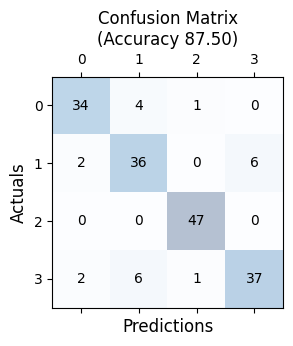

In [27]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

If things went as expected, you should around 85% accuracy result!!

At this point, you can explore different x-vector model configurations for feature extraction and alternative models to the linear SVM. Notice that it may be difficult to improve this strong system. Finally, you can generate the final prediction file and make a submission to the  [Kaggle competition](https://www.kaggle.com/t/312cd4200cfb4e138ea9372ce5bc33fd):

The setup in the second experiment:
- The model is trained on the train dataset.
- The embedding used is lang-id-voxlingua107-ecapa

In [10]:
param_grid_lr = {
    'penalty': ['l2', 'l1'],
    'C': [1, 5, 8, 10, 12],
    'solver': ['saga', 'liblinear'],
    'max_iter': [2000],
}

lr = LogisticRegression()

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(train_data, train_labels)
lr = grid_search_lr.best_estimator_

print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best score: ", grid_search_lr.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lr.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Logistic Regression',
                           'best_gs_score': grid_search_lr.best_score_,
                           'test_accuracy': accuracy_score(lr.predict(dev_data), dev_labels)})

/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model

Best hyperparameters:  {'C': 10, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.9441666666666666
Test Accuracy  : 95.45 %


In [11]:
param_grid_svc = {
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
grid_search_svc.fit(train_data, train_labels)

svc = SVC(**grid_search_svc.best_params_)
svc.fit(train_data, train_labels)

print("Best hyperparameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(svc.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'SVM',
                           'best_gs_score': grid_search_svc.best_score_,
                           'test_accuracy': accuracy_score(svc.predict(dev_data), dev_labels)})

Best hyperparameters:  {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
Best score:  0.9416666666666667
Test Accuracy  : 96.02 %


In [12]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(train_data, train_labels)
rf = grid_search_rf.best_estimator_

print("Best hyperparameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(rf.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Random Forest',
                           'best_gs_score': grid_search_rf.best_score_,
                           'test_accuracy': accuracy_score(rf.predict(dev_data), dev_labels)})

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 500}
Best score:  0.8983333333333334
Test Accuracy  : 92.05 %


In [13]:
# create the base estimators
estimators = [('rf', rf), ('svc', svc), ('lr', lr)]

# create the stacking classifier
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

stacking_clf.fit(train_data, train_labels)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(stacking_clf.predict(dev_data), dev_labels)*100))

Test Accuracy  : 96.02 %


In [16]:
#!pip install pandas
import pandas as pd

pd.DataFrame(best_model_results).sort_values(by='test_accuracy', ascending=False)

  Using cached pytz-2024.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 73.2 MB/s eta 0:00:0000:0100:01
Using cached pytz-2024.1-py2.py3-none-any.whl (505 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 33.2 MB/s eta 0:00:00


,name,best_gs_score,test_accuracy
1,SVM,0.941667,0.960227
0,Logistic Regression,0.944167,0.954545
2,Random Forest,0.898333,0.920455


In [28]:
model = svc

dev_results = model.predict(dev_data) #  Predict dev
evl_results = model.predict(evl_data) #  Predict test

In [29]:
ref, hyp = dev_labels, dev_results
print(classification_report(ref, hyp, target_names=LANGUAGES))
print(accuracy_score(ref, hyp))

              precision    recall  f1-score   support

         CHI       0.95      0.97      0.96        39
         GER       0.89      0.95      0.92        44
         HIN       1.00      1.00      1.00        47
         ITA       1.00      0.91      0.95        46

    accuracy                           0.96       176
   macro avg       0.96      0.96      0.96       176
weighted avg       0.96      0.96      0.96       176

0.9602272727272727


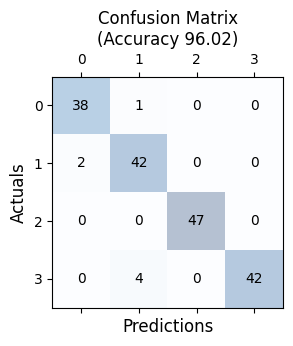

In [30]:
conf_matrix = confusion_matrix(ref, hyp)

fig, ax = plt.subplots(figsize=(3.0, 3.0))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center')

plt.xlabel('Predictions', fontsize=12)
plt.ylabel('Actuals', fontsize=12)
plt.title(f'Confusion Matrix\n(Accuracy {100*accuracy_score(ref, hyp):.2f})', fontsize=12)
plt.show()

In [32]:
trainset = 'train' ## <--- CHANGE THIS ACCORDINGLY
transform_id = 'lang-id-voxlingua107-ecapa' ## <--- CHANGE THIS ACCORDINGLY

group, system = '01', f'svc_{trainset}_{transform_id}'
with open(f'{CWD}/g{group}_{system}.csv', 'w') as file:
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    # Save dev results
    for lang, file in zip(dev_results, dev_filenames):
        csv_writer.writerow((file, LANG2ID[lang]))
    # Save evl results
    for lang, file in zip(evl_results, evl_filenames):
        csv_writer.writerow((file, LANG2ID[lang]))
        

Third experiment's setup:
- Trained on 300 examples per language
- Embedding model used: lang-id-commonlanguage_ecapa

In [8]:
param_grid_lr = {
    'penalty': ['l2', 'l1'],
    'C': [1, 5, 8, 10, 12],
    'solver': ['saga', 'liblinear'],
    'max_iter': [2000],
}

lr = LogisticRegression()

grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1)
grid_search_lr.fit(train_data, train_labels)
lr = grid_search_lr.best_estimator_

print("Best hyperparameters: ", grid_search_lr.best_params_)
print("Best score: ", grid_search_lr.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(lr.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Logistic Regression',
                           'best_gs_score': grid_search_lr.best_score_,
                           'test_accuracy': accuracy_score(lr.predict(dev_data), dev_labels)})

/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/pmigdalek/spoken-language-processing-23-24-IST/.venv/lib/python3.10/site-packages/sklearn/linear_model

Best hyperparameters:  {'C': 1, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Best score:  0.9133333333333333
Test Accuracy  : 90.34 %


In [9]:
param_grid_svc = {
        'C': [0.1, 0.5, 1, 2, 5, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'gamma': ['scale', 'auto']
}

svc = SVC()
grid_search_svc = GridSearchCV(svc, param_grid_svc, cv=5, n_jobs=-1)
grid_search_svc.fit(train_data, train_labels)

svc = SVC(**grid_search_svc.best_params_)
svc.fit(train_data, train_labels)

print("Best hyperparameters: ", grid_search_svc.best_params_)
print("Best score: ", grid_search_svc.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(svc.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'SVM',
                           'best_gs_score': grid_search_svc.best_score_,
                           'test_accuracy': accuracy_score(svc.predict(dev_data), dev_labels)})

Best hyperparameters:  {'C': 2, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best score:  0.9225
Test Accuracy  : 92.05 %


In [10]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)

grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)
grid_search_rf.fit(train_data, train_labels)
rf = grid_search_rf.best_estimator_

print("Best hyperparameters: ", grid_search_rf.best_params_)
print("Best score: ", grid_search_rf.best_score_)
print("Test Accuracy  : {:.2f} %".format(accuracy_score(rf.predict(dev_data), dev_labels)*100))

best_model_results.append({'name': 'Random Forest',
                           'best_gs_score': grid_search_rf.best_score_,
                           'test_accuracy': accuracy_score(rf.predict(dev_data), dev_labels)})

Best hyperparameters:  {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 500}
Best score:  0.8766666666666666
Test Accuracy  : 89.20 %


In [11]:
import pandas as pd

pd.DataFrame(best_model_results).sort_values(by='test_accuracy', ascending=False)

,name,best_gs_score,test_accuracy
1,SVM,0.922500,0.920455
0,Logistic Regression,0.913333,0.903409
2,Random Forest,0.876667,0.892045


## 2.2 Using self-supervised pre-trained models

The goal of this part of the laboratory is to expose students to modern tools and methods for speech classification.
In particular, we will use the [s3prl](https://github.com/s3prl/s3prl) toolkit to build a native language identification system based on self-supervised learning (SSL) models as feature extraction.

[s3prl](https://github.com/s3prl/s3prl) is an open source toolkit, which stands for Self-Supervised Speech Pre-training and Representation Learning. Self-supervised speech pre-trained models are called upstream in this toolkit and are utilized in various downstream tasks.

The toolkit permits pre-training upstream models, load already pre-trained upstream models and/or utilize these upstream models in lots of downstream tasks already defined.

For this lab, the faculty team configured a downstream task and a simple model specifically for our native language identification task and data. The model consists of a projection layer, followed by an average pooling, and a linear output layer.

In this part of the lab, students are  expected to *play* with the different upstream models to build the best possible native language identification system. 
In particular, students are encouraged to explore and discover which of the available SSL models can be a better candidate for their classification system. Note that using a large SSL model will make the training process very slow. So, you must choose wisely depending for instance on the reported performance in similar tasks.

Besides playing with the different upstream models, interested students can try to modify some of the details of the "expert" downstream model. This can be done following some of the many examples already included in the toolkit as a starting point, but it may be challenging. 

**In contrast to the x-vector based system and the notebook of Part 1, for the SSL system, we will make use of some Python scripts that are part of the S3PRL framework. These are typically run in a terminal, so, some of the following steps may be simpler to run in a terminal, rather than as cell in the Notebook itself.**

### 2.2.1 Installing the S3PRL toolkit
Let's start by cloning the repository of the `s3prl` toolkit:

In [6]:
!git clone https://github.com/s3prl/s3prl.git

Cloning into 's3prl'...
Updating files:  31% (305/975)
Updating files:  32% (312/975)
Updating files:  33% (322/975)
Updating files:  34% (332/975)
Updating files:  35% (342/975)
Updating files:  36% (351/975)
Updating files:  37% (361/975)
Updating files:  38% (371/975)
Updating files:  39% (381/975)
Updating files:  40% (390/975)
Updating files:  41% (400/975)
Updating files:  42% (410/975)
Updating files:  43% (420/975)
Updating files:  44% (429/975)
Updating files:  44% (435/975)
Updating files:  45% (439/975)
Updating files:  46% (449/975)
Updating files:  47% (459/975)
Updating files:  48% (468/975)
Updating files:  49% (478/975)
Updating files:  50% (488/975)
Updating files:  51% (498/975)
Updating files:  52% (507/975)
Updating files:  53% (517/975)
Updating files:  54% (527/975)
Updating files:  55% (537/975)
Updating files:  56% (546/975)
Updating files:  57% (556/975)
Updating files:  58% (566/975)
Updating files:  59% (576/975)
Updating files:  60% (585/975)
Updating files:

A new folder named  `s3prl/` with the contents of the toolkit has been created. We'll now install the toolkit itself.

In [30]:
S3PRLDIR = CWD + '/s3prl/'
os.chdir(S3PRLDIR)
#!pip install -e .

### 2.2.2 Configuring the downstream task
Let's create the downstream native language identification task. In the `s3prl/downstream/` there are plenty of examples. The faculty team took one of those as an example to create the configuration needed for this lab assignment. Let's download and copy it to the downstream folder: 

In [33]:
os.chdir(f'{S3PRLDIR}/s3prl/downstream/') #  change to the downstream folder
!wget http://groups.tecnico.ulisboa.pt/speechproc/pf24/lab2/nli_s3prl_downstream.tgz # <--- download the lab specific downstream task
!tar -xzvf nli_s3prl_downstream.tgz  #  unzip
#!rm nli_s3prl_downstream.tgz
os.chdir(S3PRLDIR)

Nie mo�na odnale�� okre�lonego pliku.


tar: Error opening archive: Failed to open 'nli_s3prl_downstream.tgz'


Have a look to the contents of the folder `s3prl/downstream/native_language_identification/`. There are some important files that help to define the task:
- `dataset.py`: this file provides the class that permits loading the ETS data. Something similar to the ETS class used in previously, but following the formatting rules of the s3prl toolkit. **You don't need to change anything here**.
- `expert.py`: this file defines the expert downstream task. In this case, the expert takes the output of the upstream model (configurable), applies a projection layer, and then a classification model (configurable) to obtain the final predictions. **You don't need to change anything here**.
- `model.py`: this file contains the definitions of the model after the projection. We could include several configurations that can later be selected when we run the actual experiment. The model included is just an average pooling (that reduces the time dimension to a single vector) followed by a linear output layer. **You don't need to change anything here, but you may want to explore other configurations following the examples of other downstream tasks included in s3prl**.
- `config.yaml`: this file permits configuring some parameters of your experiment, including the path that contains the task data and the training set that is going to be used (either train or train100). 

Let's configure our experiment: 

Edit the 'file_path' entry in the configuration file `downstream/native_language_identification/config.yaml` to the folder containing the data:

```yaml
downstream_expert:
    datarc:
        file_path: "your_path/ets_data"
```



And also edit the config file, to use either the "train100" partition or the total training data "train"  by just editing the following entry of the `downstream/native_language_identification/config.yaml`:

```yaml
downstream_expert:
    datarc:
        ...
        train: "train100"
```

You may also want to reduce the number of training steps to 1000 or 2000 for quick experimentation of different configurations:

```yaml
runner:
  total_steps: 5000
  ...
```


### 2.2.3 Training the downstream model
Now it's time for training. For that, we will use the Pythons script `run_downstream.py` in train mode and in which we will set:
- an arbitrary name for identifying this experiment, in which the results will be saved ( `ExpName`)
- the upstream model to be used, for instance, `fbank`. You can check for more SSL pretrained available models  here https://s3prl.github.io/s3prl/tutorial/upstream_collection.html
- the downstream task, in this case "native_language_identification"


```bash
python3 run_downstream.py -n ExpName -m train -u fbank -d native_language_identification
```

Since this can take a while (actually, a lot depending on the chosen upstream model and your  computational resources), you probably want to run this in a terminal, rather than inside the Notebook:


In [ ]:
os.chdir(f'{S3PRLDIR}/s3prl')
!python3 run_downstream.py -n fbank -m train -u fbank -d native_language_identification


HINT: if the training process is interrupted for some reason, you can continue from the last saved checkpoint (a checkpoint is saved every 200 iterations):

```bash
python3 run_downstream.py -m train -e result/downstream/fbank/states-XXXX.ckpt
```

### 2.2.4 Classification and performance of the dev set

The training process created a folder containing some training results `result/downstream/{ExpName}`:

In [ ]:

os.chdir(f'{S3PRLDIR}/s3prl')
!ls result/downstream/fbank/

Some interesting files: 
- `dev_predict.txt` contains the predictions on the dev set, 
- `dev-best.ckpt` contains the model parameters for the best checkpoint,
- `log.log` contains information of the training process, including the identification accuracy in the train and dev sets. 

Let's load the prediction and reference files to compute the performance of our system:

In [ ]:
hyp = [line.strip().split()[-1] for line in open(f'result/downstream/fbank/dev_predict.txt')]
ref = [line.strip().split()[-1] for line in open(f'result/downstream/fbank/dev_truth.txt')]

print(classification_report(ref, hyp, target_names=LANGUAGES))
print(accuracy_score(ref, hyp))

That was disappointing!! The `fbank` is **a very bad upstream model!!!**. 

The goal of this lab is for you to get familiar with and experiment with some of the most popular speech SSL models. You can start with those commented in the theoretical lessons or the ones that have shown good performance in similar tasks. Be careful (and wise) in your decisions: experiments may be slow! 

### 2.2.5 Classification of the evl set 

Now that we already trained our downstream model, we can use it to predict  the blind evl set. For this purpose, we will use again the `run_downstream.py` script in evaluate mode and we need to select the actual model to use:


```bash
python3 run_downstream.py -m evaluate -e result/downstream/fbank/dev-best.ckpt
```

NOTE: Ignore the test accuracy reported at the end (we  don't have the groundtruth).

In [ ]:
!python3 run_downstream.py -m evaluate -e result/downstream/fbank/dev-best.ckpt

The `test_predict.txt` file contains the predictions of this model for the evl set.

### 2.2.6 Create the final predictions file and submit to the challenge

Like in Part 1, we will create the predictions file in the expected format:

In [ ]:

trainset = 'train100'
upstream_id = 'fbank' ## <--- CHANGE THIS ACCORDINGLY
group, system = '00', f'ssl_{trainset}_{upstream_id}'

filename_dev = f'{S3PRLDIR}/s3prl/result/downstream/{upstream_id}/dev_predict.txt'
filename_evl = f'{S3PRLDIR}/s3prl/result/downstream/{upstream_id}/test_predict.txt'


with open(f'{CWD}/g{group}_{system}.csv', 'w') as file:
    
    csv_writer = csv.writer(file) # CSV writer
    csv_writer.writerow(('fileId', 'Lang')) # Header of the CSV

    results_dev = [l.strip().split() for l in open(filename_dev, 'r')]
    results_evl = [l.strip().split() for l in open(filename_evl, 'r')]

    # Save dev results
    for file_id, lang in results_dev:
        file_id = file_id.split('-')[-1]
        lang = LANG2ID[lang]
        csv_writer.writerow((file_id, lang))
        
    # Save evl results
    for file_id, lang in results_evl:
        file_id = file_id.split('-')[-1]
        lang = LANG2ID[lang]
        csv_writer.writerow((file_id, lang))

Finally, you can submit your prediction(s) in the  [Kaggle competition](https://www.kaggle.com/t/312cd4200cfb4e138ea9372ce5bc33fd).



# Contacts and support
You can contact the professors during the classes or the office hours.

Particularly, for this second laboratory assignment, you should contact Prof. Alberto Abad: alberto.abad@tecnico.ulisboa.pt


